In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Layer
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt

/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_81919/3200721590.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-07-05 17:26:50.800483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 's

In [2]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [3]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [4]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

print(X_train.shape)

#y_test = X_test['Class']
#X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#X_test = X_test.values

(227451, 29)


In [6]:
class_0 = X_test[X_test.Class == 0]
class_1 = X_test[X_test.Class == 1]

total_size = len(X_test)
desired_size_class_1 = int(total_size * 0.4)
desired_size_class_0 = total_size - desired_size_class_1

class_1_sampled = class_1.sample(n=desired_size_class_1, replace=True, random_state=42)
class_0_sampled = class_0.sample(n=desired_size_class_0, replace=True, random_state=42)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

X_test = balanced_data.drop('Class', axis=1)
y_test = balanced_data['Class']

X_test = X_test.values
y_test = y_test.values
print(y_test)

[0 0 0 ... 1 1 1]


In [7]:
print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

34178
22784


In [8]:
input_dim = X_train.shape[1]
input_shape=(29,)
print(input_dim)
original_dim = input_dim  # Esempio di dimensione dell'input originale
intermediary_dims = [20, 10 ,8]
latent_dim = 2  # Esempio di dimensione dello spazio latente

29


In [9]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

# Definizione della classe MultivariateNormalTriLLayer
class MultivariateNormalTriLLayer(tfkl.Layer):
    def __init__(self, latent_dim, **kwargs):
        super(MultivariateNormalTriLLayer, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.untransformed_scale_tril = self.add_weight(name='untransformed_scale_tril',
                                                        shape=(self.latent_dim * (self.latent_dim + 1) // 2,),
                                                        initializer='random_normal',
                                                        trainable=True)
        super(MultivariateNormalTriLLayer, self).build(input_shape)

    def call(self, inputs):
        loc = inputs[..., :self.latent_dim]
        scale_tril = tfp.math.fill_triangular(self.untransformed_scale_tril)
        dist = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        sample = dist.sample()
        return sample  # Return the sample, not the distribution object

# Definizione della funzione dense_layers
def dense_layers(intermediary_dims):
    return tfk.Sequential([
        tfkl.Dense(units, activation='relu') for units in intermediary_dims
    ])

# Definizione del decoder come una classe Layer
class Decoder(tfkl.Layer):
    def __init__(self, original_dim, intermediary_dims, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.decoder_hidden = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu') for units in intermediary_dims
        ] + [
            tf.keras.layers.Dense(original_dim, activation='sigmoid')
        ])

    def call(self, inputs):
        return self.decoder_hidden(inputs)

# Definizione del modello VAE
class VAE(tf.keras.Model):
    def __init__(self, original_dim, intermediary_dims, latent_dim, prior, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.intermediary_dims = intermediary_dims
        self.latent_dim = latent_dim
        self.prior = prior

        # Encoder
        self.encoder_inputs = tf.keras.Input(shape=(original_dim,), name='encoder_input')
        self.encoder = self.build_encoder()

        # Decoder
        self.decoder = Decoder(original_dim, intermediary_dims)

    def build_encoder(self):
        x = dense_layers(self.intermediary_dims)(self.encoder_inputs)
        params = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(self.latent_dim), activation=None)(x)
        z = MultivariateNormalTriLLayer(self.latent_dim)(params)
        return tf.keras.Model(self.encoder_inputs, [z, params], name='encoder')

    @tf.function
    def call(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        z_sample, _ = self.encoder(inputs)  # Otteniamo sia z_sample che params
        reconstructed = self.decoder(z_sample)
        return reconstructed

    def compute_kl_divergence(self, q_z_x_params):
        q_distribution = tfd.MultivariateNormalTriL(loc=q_z_x_params[..., :self.latent_dim],
                                                    scale_tril=tfp.math.fill_triangular(q_z_x_params[..., self.latent_dim:]))
        p_distribution = self.prior
        return tfd.kl_divergence(q_distribution, p_distribution)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            reconstructed = self(data)
            reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstructed)
            reconstruction_loss *= self.original_dim
            print(reconstruction_loss)
            z_sample, q_z_x_params = self.encoder(data)
            kl_divergence = tf.reduce_mean(self.compute_kl_divergence(q_z_x_params))

            elbo_loss = reconstruction_loss + kl_divergence
        gradients = tape.gradient(elbo_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": elbo_loss, "reconstruction_loss": reconstruction_loss, "kl_divergence": kl_divergence}

# Definizione dei parametri
input_dim = X_train.shape[1]
original_dim = input_dim
intermediary_dims = [20, 10, 8]
latent_dim = 2
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim), scale_diag=tf.ones(latent_dim))

# Creazione dell'istanza del modello VAE
vae = VAE(original_dim, intermediary_dims, latent_dim, prior)

# Compilazione del modello specificando la loss
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Allenamento del modello
history = vae.fit(X_train, X_train, epochs=50, batch_size=64)


Epoch 1/50
Tensor("mul:0", shape=(), dtype=float32)


/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Tensor("mul:0", shape=(), dtype=float32)
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - kl_divergence: 0.5277 - loss: 38.2174 - reconstruction_loss: 37.6896
Epoch 2/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_divergence: 0.0460 - loss: 37.6367 - reconstruction_loss: 37.5907
Epoch 3/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_divergence: 0.0103 - loss: 37.5389 - reconstruction_loss: 37.5286
Epoch 4/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_divergence: 0.0104 - loss: 37.4981 - reconstruction_loss: 37.4877
Epoch 5/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_divergence: 0.0129 - loss: 37.4733 - reconstruction_loss: 37.4605
Epoch 6/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_divergence: 0.0127 - loss: 37.4667 - reconstruction_loss: 37.4540
Epoch 7/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - kl_divergence: 0.0126 - loss: 37.4604 - reconstruction_loss: 37.4478
Epoch 8/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_divergence: 0.0128 - loss: 37.4591

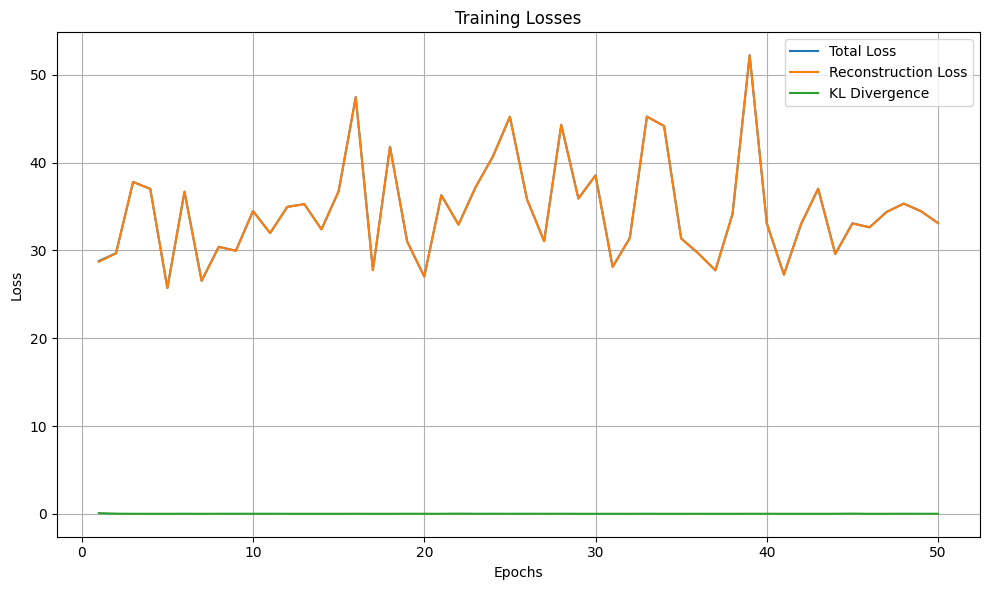

In [10]:
# Estrazione della loss
loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_divergence = history.history['kl_divergence']

# Plot della loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Total Loss')
plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
plt.plot(epochs, kl_divergence, label='KL Divergence')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [11]:
# Calcolo della perdita di ricostruzione su X_test
reconstructed = vae.decoder(vae.encoder(X_test)).numpy()
reconstruction_loss = np.mean(np.square(X_test - reconstructed), axis=1)

print(reconstruction_loss)

# Definizione di una soglia arbitraria (può essere ottimizzata)
threshold = 2.5

# Creazione di un array binario per le previsioni basate sulla soglia
predictions = (reconstruction_loss > threshold).astype(np.int32)


[  0.57180156   0.67633004   1.38860613 ...   1.34650931   3.6738637
 110.06458598]


In [12]:
# Definisci la funzione per calcolare le metriche in base al threshold
def calculate_metrics(y_test, predictions, reconstruction_loss):
    # Calcolo delle metriche
    auc = roc_auc_score(y_test, reconstruction_loss)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    return auc, accuracy, precision, recall, f1, tn, fp, fn, tp

nan_indices = np.isnan(reconstruction_loss)
if np.any(nan_indices):
    print(f"Found NaN values in reconstruction_loss at indices: {np.where(nan_indices)}")

# Calcolo delle metriche per la soglia arbitraria
auc, accuracy, precision, recall, f1, tn, fp, fn, tp = calculate_metrics(y_test, predictions, reconstruction_loss)

print(f'Metriche con soglia arbitraria:')
print(f'AUC: {auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
print()

# Ottimizzazione del threshold utilizzando la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, reconstruction_loss)
roc_auc_scores = [roc_auc_score(y_test, reconstruction_loss) for threshold in thresholds_roc]
optimal_threshold_roc = thresholds_roc[np.argmax(roc_auc_scores)]

# Applica il threshold ottimizzato dalla curva ROC
predictions_roc = (reconstruction_loss > optimal_threshold_roc).astype(np.int32)

# Calcola le metriche utilizzando l'optimal_threshold_roc
auc_roc, accuracy_roc, precision_roc, recall_roc, f1_roc, tn_roc, fp_roc, fn_roc, tp_roc = calculate_metrics(y_test, predictions_roc, reconstruction_loss)

print(f'ROC Curve Optimization:')
print(f'Optimal Threshold (ROC): {optimal_threshold_roc:.4f}')
print(f'AUC (ROC): {auc_roc:.4f}')
print(f'Accuracy (ROC): {accuracy_roc:.4f}')
print(f'Precision (ROC): {precision_roc:.4f}')
print(f'Recall (ROC): {recall_roc:.4f}')
print(f'F1-score (ROC): {f1_roc:.4f}')
print(f'TN (ROC): {tn_roc}, FP (ROC): {fp_roc}, FN (ROC): {fn_roc}, TP (ROC): {tp_roc}')
print()

# Ottimizzazione del threshold utilizzando la curva precision-recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_loss)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold_pr = thresholds_pr[np.argmax(f1_scores)]

# Applica il threshold ottimizzato dalla curva precision-recall
predictions_pr = (reconstruction_loss > optimal_threshold_pr).astype(np.int32)

# Calcola le metriche utilizzando l'optimal_threshold_pr
auc_pr, accuracy_pr, precision_pr, recall_pr, f1_pr, tn_pr, fp_pr, fn_pr, tp_pr = calculate_metrics(y_test, predictions_pr, reconstruction_loss)

print(f'Precision-Recall Curve Optimization:')
print(f'Optimal Threshold (PR): {optimal_threshold_pr:.4f}')
print(f'AUC (PR): {auc_pr:.4f}')
print(f'Accuracy (PR): {accuracy_pr:.4f}')
print(f'Precision (PR): {precision_pr:.4f}')
print(f'Recall (PR): {recall_pr:.4f}')
print(f'F1-score (PR): {f1_pr:.4f}')
print(f'TN (PR): {tn_pr}, FP (PR): {fp_pr}, FN (PR): {fn_pr}, TP (PR): {tp_pr}')


Metriche con soglia arbitraria:
AUC: 0.9531
Accuracy: 0.9116
Precision: 0.9196
Recall: 0.8537
F1-score: 0.8854
TN: 32478, FP: 1700, FN: 3333, TP: 19451

ROC Curve Optimization:
Optimal Threshold (ROC): inf
AUC (ROC): 0.9531
Accuracy (ROC): 0.6000
Precision (ROC): 0.0000
Recall (ROC): 0.0000
F1-score (ROC): 0.0000
TN (ROC): 34178, FP (ROC): 0, FN (ROC): 22784, TP (ROC): 0

Precision-Recall Curve Optimization:
Optimal Threshold (PR): 2.3483
AUC (PR): 0.9531
Accuracy (PR): 0.9246
Precision (PR): 0.9165
Recall (PR): 0.8928
F1-score (PR): 0.9045
TN (PR): 32324, FP (PR): 1854, FN (PR): 2442, TP (PR): 20342


/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
